# Machine Learning - Regression & Classification Models

Can we predict the popularity of a song for a certain genre based on its audio features? Can we predict the genre of a song based on its audio features and lyrics?

We approached these questions differently; for predicting popularity, we used a K-Nearest Neighbor Regression Model and for predicting genre, we used a K-Nearest Neighbor Classification Model. For both models, we utilized the audio features calculated by Spotify. Specifically we used the following features (as described on [Spotify's Web API Reference](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)):

 - **Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
 - **Danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
 - **Energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
 - **Instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
 - **Loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). ?Values typical range between -60 and 0 db.
 - **Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
 - **Time Signature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).
 - **Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).


In [1]:
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
pd.options.display.max_rows = 8
%matplotlib inline

In [2]:
tracks = pd.read_csv("/data301/share/final_tracks_lyrics.csv")
tracks = tracks.dropna()

## Regression - Predicting Popularity

For predicting popularity, we used a regression model. In addition, we used different audio features for each top genre - pop, rap, and country. Some feature choices were similar across all three genres, so we will highlight the unique choices.

The popularity is an index we gathered from Spotify that is described on their [documenation](https://developer.spotify.com/documentation/web-api/reference/tracks/get-track/):

>**Popularity**: The popularity of the track. The value will be between 0 and 100, with 100 being the most popular.
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently.

For *pop*, we included danceability because pop is often known for its upbeat, contagious energy. Danceability is a great way to determine this, while speechiness is better left out of the features because pop is more focused around the sound than the lyrical instensity.

For *rap*, we included speechiness because a fundamental pillar of hip hop and rap is the lyrical diversity and intensity, while acousticness is not a common feature of rap.

For *country*, we included acousticness because country often features acoustic guitar or similar sounds. We included danceability because much of modern country is focused around dancing and high energy. 

With the audio features, we used the top 1000 words from our TF-IDF analysis of the song lyrics we collected. This would help us find similar songs, given the subject matter and use of vocabulary.

In [3]:
pop_features = ["danceability", "energy", "instrumentalness",
                     "loudness", "tempo", "time_signature",
                    "valence"]

rap_features = ["speechiness", "energy", "instrumentalness",
                     "loudness", "tempo", "time_signature",
                    "valence"]

country_features = ["acousticness", "danceability", "energy", "instrumentalness",
                     "loudness", "tempo", "time_signature",
                    "valence"]

To caluclate the root mean squared error for our regression model for each genre, we split up the dataset into to two samples (one for the training set and one for the test set). We then fed the training set into a pipeline to compute the *k* neighbors that would result in a the highest negative mean squared error. Once we obtained that *k*, we predicted the popularity for our test set and calculated the test error for our prediction model.

In [4]:
def get_mean_sq_error_for_popularity(spec_genre):
    genre = tracks[tracks[spec_genre] == True]
    train = genre.sample(frac=.5)
    test = genre.drop(train.index)

    if spec_genre == "pop":
        variables = pop_features
    elif spec_genre == "rap":
        variables = rap_features
    else:
        variables = country_features
    
    metrics = train.loc[:, variables]

    lyrics = train.loc[:, '0':'999']
    X_train = pd.concat([metrics, lyrics], axis=1)
    y_train = train["popularity"]

    metrics = test.loc[:, variables]

    lyrics = test.loc[:, '0':'999']
    X_test = pd.concat([metrics, lyrics], axis=1)
    y_test = test["popularity"]

    X_train_std = (X_train - X_train.mean()) / X_train.std()
    X_test_std = (X_test - X_train.mean()) / X_train.std()
    
    
    ks = pd.Series(range(1, 90, 5)) 
    ks.index = ks

    def get_cv_error_for_knn(k):
        scaler = StandardScaler()
        model = KNeighborsRegressor(n_neighbors=k)
        pipeline = Pipeline([('transform', scaler), ('fit', model)])
        return cross_val_score(pipeline, X_train, y_train, cv=10, scoring="neg_mean_squared_error").mean()

    cv_errors = ks.apply(get_cv_error_for_knn)
    cv_errors.plot.line()
    cv_errors.idxmax(), cv_errors.max()
    
    k = cv_errors.idxmax()

    def get_kNN_prediction(row):
        dists = ((row - X_train_std) ** 2).sum(axis=1)
        inds_nearest = dists.sort_values().index[:k]
        return y_train[inds_nearest].mean()

    # test error
    y_test_pred = X_test_std.apply(get_kNN_prediction, axis=1)
    predictions = pd.DataFrame(columns=["popularity", "pred"])
    predictions["popularity"] = y_test
    predictions["pred"] = y_test_pred
    mse = ((y_test_pred - y_test) ** 2).mean()
    rmse = np.sqrt(mse)
    return (rmse, predictions)
    
    

Pop:  12.174705012
Rap:  10.508605938
Country:  12.0508738745


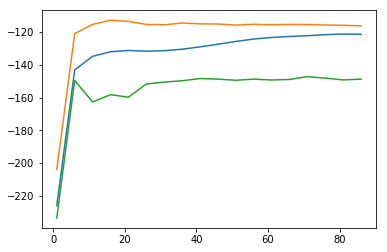

In [5]:
pop_rmse = get_mean_sq_error_for_popularity("pop")
rap_rmse = get_mean_sq_error_for_popularity("rap")
country_rmse = get_mean_sq_error_for_popularity("country")

print("Pop: ", pop_rmse[0])
print("Rap: ", rap_rmse[0])
print("Country: ", country_rmse[0])

pop_pred = pop_rmse[1]
rap_pred = rap_rmse[1]
country_pred = country_rmse[1]


### Representative Observations

#### Pop: The Chainsmokers - Roses

In [6]:
roses = tracks[(tracks.name == "Roses") & (tracks.artist == "The Chainsmokers")]
roses[pop_features]

,danceability,energy,instrumentalness,loudness,tempo,time_signature,valence
4848,0.713,0.802,0.00377,-7.055,100.001,4,0.343


In [7]:
pop_pred["name"] = tracks.loc[pop_pred.index, "name"]
pop_pred["artist"] = tracks.loc[pop_pred.index, "artist"]
pop_pred[(pop_pred.name == "Roses") & (pop_pred.artist == "The Chainsmokers")].pred

Series([], Name: pred, dtype: float64)

In [8]:
pop_pred[(pop_pred.name == "Roses") & (pop_pred.artist == "The Chainsmokers")].popularity

Series([], Name: popularity, dtype: int64)

#### Rap: Chance The Rapper - Same Drugs

In [9]:
samedrugs = tracks[(tracks.name == "Same Drugs") & (tracks.artist == "Chance The Rapper")]
samedrugs[rap_features]

,speechiness,energy,instrumentalness,loudness,tempo,time_signature,valence
4441,0.0555,0.293,0.00001,-9.52,180.297,4,0.531


In [10]:
rap_pred["name"] = tracks.loc[rap_pred.index, "name"]
rap_pred["artist"] = tracks.loc[rap_pred.index, "artist"]
rap_pred[(rap_pred.name == "Same Drugs") & (rap_pred.artist == "Chance The Rapper")].pred

Series([], Name: pred, dtype: float64)

In [11]:
rap_pred[(rap_pred.name == "Same Drugs") & (rap_pred.artist == "Chance The Rapper")].popularity

Series([], Name: popularity, dtype: int64)

#### Country: Jason Aldean - My Kinda Party

In [12]:
party = tracks[(tracks.name == "My Kinda Party") & (tracks.artist == "Jason Aldean")]
party[country_features]

,acousticness,danceability,energy,instrumentalness,loudness,tempo,time_signature,valence
2339,0.0167,0.41,0.9,0.000011,-4.249,176.962,4,0.558


In [13]:
country_pred["name"] = tracks.loc[country_pred.index, "name"]
country_pred["artist"] = tracks.loc[country_pred.index, "artist"]
country_pred[(country_pred.name == "My Kinda Party") & (country_pred.artist == "Jason Aldean")].pred

2339    58.647887
Name: pred, dtype: float64

In [14]:
country_pred[(country_pred.name == "My Kinda Party") & (country_pred.artist == "Jason Aldean")].popularity

2339    65
Name: popularity, dtype: int64

## Classification - Predicting Genre

For predicting genre, we used a classification model. Unlike our regression model, we used one list of audio features for the entire dataset we were training and testing on.

With the audio features, we used the top 1000 words from our TF-IDF analysis of the song lyrics we collected. This would help us find similar songs, given the subject matter and use of vocabulary.

In order to keep the classification model succinct, we limited the Y of our model to the four most popular genres: pop, hip hop, country, and house. 

In [15]:
final_tracks_lyrics = pd.read_csv("/data301/share/final_tracks_lyrics.csv")
final_tracks_genres = pd.read_csv("/data301/share/final_tracks.csv")

In [16]:
lyrics = final_tracks_lyrics.loc[:, "0":"999"]
tracks = pd.concat([final_tracks_genres, lyrics], axis=1)
tracks = tracks.dropna()
tracks_main_genres = tracks[(tracks["main_genre"] == "pop") | (tracks["main_genre"] == "hip hop") 
                            | (tracks["main_genre"] == "country") | (tracks["main_genre"] == "house")]

To caluclate the accuracy for our classification model of our genre predictor, we split up the dataset into to two samples (one for the training set and one for the test set). We then fed the training set into a pipeline to compute the *k* neighbors that would result in a the highest accuracy. Once we obtained that *k*, we predicted the genre for our test set and calculated the test error for our prediction model.

In [17]:
train = tracks_main_genres.sample(frac=.5)
test = tracks_main_genres.drop(train.index)

metrics = train.loc[:, ["acousticness", "danceability", "energy", "speechiness", "instrumentalness",
                 "loudness", "tempo", "time_signature",
                "valence", "popularity"]]
lyrics = train.loc[:, '0':'999']
X_train = pd.concat([metrics, lyrics], axis=1)
y_train = train["main_genre"]

metrics = test.loc[:, ["acousticness", "danceability", "energy", "speechiness", "instrumentalness",
                 "loudness", "tempo", "time_signature",
                "valence", "popularity"]]
lyrics = test.loc[:, '0':'999']
X_test = pd.concat([metrics, lyrics], axis=1)

y_test = test["main_genre"]

X_train_std = (X_train - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_train.mean()) / X_train.std()

It is important note, due to the high count of pop songs from Spotify, our training set was majority pop songs. This will be important to note in the results of our machine learning.

In [18]:
y_train.value_counts()

pop        476
hip hop    220
country     94
house       78
Name: main_genre, dtype: int64

(56, 0.54728084300717439)

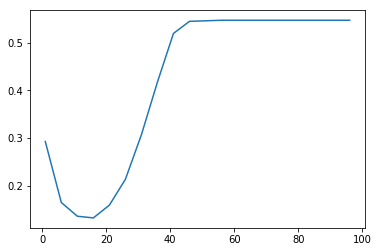

In [19]:
from sklearn.neighbors import KNeighborsClassifier

ks = pd.Series(range(1, 100, 5)) 
ks.index = ks

def get_cv_error_for_knn(k):
    scaler = StandardScaler()
    model = KNeighborsClassifier(n_neighbors=k)
    pipeline = Pipeline([('transform', scaler), ('fit', model)])
    return cross_val_score(pipeline, X_train, y_train, cv=10, scoring="accuracy").mean()

cv_errors = ks.apply(get_cv_error_for_knn)
cv_errors.plot.line()
cv_errors.idxmax(), cv_errors.max()

In [20]:
k = cv_errors.idxmax()

def get_kNN_prediction(row):
    dists = ((row - X_train_std) ** 2).sum(axis=1)
    inds_nearest = dists.sort_values().index[:k]
    return y_train[inds_nearest].value_counts().idxmax()

# test error
pred = X_test_std.apply(get_kNN_prediction, axis=1)
actual = y_test

In [21]:
precision = (((pred == "pop") & (actual == "pop")).sum() /
            (pred == "pop").sum())
recall = (((pred == "pop") & (actual == "pop")).sum() /
            (actual == "pop").sum())

precision, recall

(0.53179190751445082, 1.0)

When computing the precision and recall of our model, we found our precision for the pop genre to be 0.53 with a recall of 1.0. This shows that the model has the tendency to put songs into the pop genre due to the wide variety of audio features that so many pop songs demonstrate and the fact that the majority of songs in our dataset are of the pop genre.

In [22]:
precision = (((pred == "hip hop") & (actual == "hip hop")).sum() /
            (pred == "hip hop").sum())
recall = (((pred == "hip hop") & (actual == "hip hop")).sum() /
            (actual == "hip hop").sum())

precision, recall

(0.5, 0.0043668122270742356)

In [23]:
precision = (((pred == "country") & (actual == "country")).sum() /
            (pred == "country").sum())
recall = (((pred == "country") & (actual == "country")).sum() /
            (actual == "country").sum())

precision, recall

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


(nan, 0.0)

In [24]:
precision = (((pred == "house") & (actual == "house")).sum() /
            (pred == "house").sum())
recall = (((pred == "house") & (actual == "house")).sum() /
            (actual == "house").sum())

precision, recall

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


(nan, 0.0)

Because of the vast majority of songs being pop, our classification model isnt great. Looking back, it would have been a better idea to somehow try to collect the most popular songs from a few different genres, rather than just the top 200 charts, which mainly consist of pop artists. Our regression model would also benefit from this. Also, if we could have gotten the actual genre for every individual song rather than from the aritst and generalizing the genre across the artist's different songs, our models would be better.